In [1]:
%dhist
#%dirs
#%env

Directory history (kept in _dh)
0: /media/boba/DATA/boba/Working/Kaggle/2017-05-05 SberBank/Jupiter


In [170]:
%time
!git status
#!git add .
#!git commit -a -m '85.csv best LB=0.31620 new params from sk CV'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   sb-v01-head-01-rmse-03-multi.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
#import keras
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "../Data"]).decode("utf8"))


data_dictionary.txt
macro.csv
macro.xlsx
sample_submission.csv
test.csv
train.csv
train.xlsx



In [4]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

In [5]:
import math
import datetime
from sklearn.preprocessing import LabelEncoder

In [6]:
# Загружаем данные. Индексом ставим timestamp.

In [7]:
macro = pd.read_csv('../Data/macro.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
train = pd.read_csv('../Data/train.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
test = pd.read_csv('../Data/test.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)

In [8]:
llist = range(0,185)
##llist = range(-60,90)

roll  = 30
xLU = macro['usdrub'].rolling(roll).mean()
xLE = macro['eurrub'].rolling(roll).mean()

xL1 = (pd.concat([100/(macro.usdrub.shift(i))    for i in llist], axis=1,keys=['L1%s' % i for i in llist])).dropna()
xL2 = (pd.concat([(macro.usdrub.shift(i))**2 for i in llist], axis=1,keys=['L2%s' % i for i in llist])).dropna()
xL3 = (pd.concat([(macro.usdrub.shift(i))**3 for i in llist], axis=1,keys=['L3%s' % i for i in llist])).dropna()
xLL =  pd.concat([xL1,xL2,xL3], axis=1) 
xLL = xL1
##xLL = (pd.concat([(macro.usdrub.shift(i)) for i in llist], axis=1,keys=['L%s' % i for i in llist])).dropna()
xLL.dropna()
del llist
##xLL.head(),xLL.tail()
xLL.shape, xLL.index.min(),xLL.index.max()

((2297, 185),
 Timestamp('2010-07-07 00:00:00', freq='D'),
 Timestamp('2016-10-19 00:00:00', freq='D'))

In [9]:
macro.shape, train.shape, test.shape, xLL.shape

((2484, 99), (30471, 291), (7662, 290), (2297, 185))

In [10]:
# Массивы для перекодировки значений в числовую форму
#ntrain, ntest = pd.concat([train,macro],axis=1,join='inner'), pd.concat([test,macro],axis=1,join='inner')

ntrain, ntest, nmacro = train.copy(), test.copy(), macro.copy()

print('macro=',macro.index.min(),macro.index.max())
print('train=',train.index.min(),train.index.max())
print('test =',test.index.min(),test.index.max())
print('xLL =',xLL.index.min(),xLL.index.max())
print 'macro=', macro.shape, 'ntrain=', ntrain.shape, 'ntest=', ntest.shape, 'xLL=', xLL.shape

('macro=', Timestamp('2010-01-01 00:00:00'), Timestamp('2016-10-19 00:00:00'))
('train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('test =', Timestamp('2015-07-01 00:00:00'), Timestamp('2016-05-30 00:00:00'))
('xLL =', Timestamp('2010-07-07 00:00:00', freq='D'), Timestamp('2016-10-19 00:00:00', freq='D'))
macro= (2484, 99) ntrain= (30471, 291) ntest= (7662, 290) xLL= (2297, 185)


In [11]:
# Очистка данных (пока в процессе продумывания)

In [12]:
def clear_datas (data) :
    
    # clear life_sq
    data['life_sq'].dropna(0);
    
    while (data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)].count()>0) :
        data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)] /= 10.0;

    iid = data[data.life_sq>data.full_sq].index
    data.ix[iid,'life_sq'] = data.ix[iid,'full_sq'];
    
    data.loc[(data.kitch_sq>1000)|(data.kitch_sq>data.life_sq)] = np.NAN
    
    return

In [13]:
# Убираем индекс, переходим на нумерацию для простоты
ntrain = ntrain.reset_index()
ntest  = ntest.reset_index()
nmacro = nmacro.reset_index()
xLL    = xLL.reset_index()
dict_col_le = {}

In [14]:
# Сериализация символьных значений

In [15]:
dict_col_le = {}
for cc in ntrain.select_dtypes(exclude=['int64', 'float64','datetime64']).columns :
    
    # Добиваем пустоты в колонке
    ntrain[cc] = ntrain[cc].fillna('NANA')
    ntest[cc]  = ntest[cc].fillna('NANA')
    
    le = LabelEncoder()
    # Заполняем класс значениями
    le.fit(list(ntrain[cc].values.astype('str')) + list(ntest[cc].values.astype('str')))
    # Перегоняем и сохраняем в словаре для будущего
    ntrain[cc] = le.transform(list(ntrain[cc].values.astype('str')))
    ntest[cc]  = le.transform(list(ntest[cc].values.astype('str')))
    
    #print(cc,le.classes_)
    dict_col_le[cc] = le
    
for cc in nmacro.select_dtypes(exclude=['int64', 'float64','datetime64']).columns :
    
    # Добиваем пустоты в колонке
    nmacro[cc] = nmacro[cc].fillna('NANA')
    
    le = LabelEncoder()
    # Заполняем класс значениями
    le.fit(list(nmacro[cc].values.astype('str')))
    # Перегоняем и сохраняем в словаре для будущего
    nmacro[cc] = le.transform(list(nmacro[cc].values.astype('str')))
    
    #print(cc,le.classes_)
    dict_col_le[cc] = le
    
# Добиваем пустоты
ntrain = ntrain.fillna(0)
ntest  = ntest.fillna(0)
nmacro = nmacro.fillna(0)

In [16]:
dict_col_le.keys()
#ntrain.child_on_acc_pre_school.unique()
#ntest.child_on_acc_pre_school.unique()
#dict_col_le['sub_area'].inverse_transform(ntrain.sub_area.unique())

['railroad_terminal_raion',
 'oil_chemistry_raion',
 'culture_objects_top_25',
 'product_type',
 'sub_area',
 'modern_education_share',
 'incineration_raion',
 'detention_facility_raion',
 'thermal_power_plant_raion',
 'radiation_raion',
 'old_education_build_share',
 'railroad_1line',
 'ecology',
 'big_market_raion',
 'water_1line',
 'nuclear_reactor_raion',
 'big_road1_1line',
 'child_on_acc_pre_school']

In [17]:
# Дополнение train полями usd, eur и расчет дополнительных результативных полей в train (стоимость м2 в usd и eur для жилой и общей площади)

In [18]:
def add_datetime (data) :
    data['day']     = data.timestamp.dt.day  
    data['month']   = data.timestamp.dt.month
    data['year']    = data.timestamp.dt.year
    data['week']    = data.timestamp.dt.week
    data['weekday'] = data.timestamp.dt.weekday
    
    month_year = (data.timestamp.dt.month + data.timestamp.dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    data['year_month_cnt'] = month_year.map(month_year_cnt_map)
    data['year_month']     = (data.timestamp.dt.month + data.timestamp.dt.year * 100)
    
    week_year = (data.timestamp.dt.week + data.timestamp.dt.year * 100)
    week_year_cnt_map = week_year.value_counts().to_dict()
    data['year_week_cnt'] = week_year.map(week_year_cnt_map)
    data['year_week']     = (data.timestamp.dt.week + data.timestamp.dt.year * 100)
    
    return

def add_features_1 (data) :
    
    #data = data.reset_index()
    
    data['build_year0']   = data.build_year;
    data.ix[data.build_year<=1500,'build_year0']=data.ix[data.build_year<=1500,'year']-2;
    
    data['full0']         = data.full_sq; data.ix[data.full_sq<=1,'full0']=50.0
    data['life0']         = data.life_sq; data.ix[data.life_sq<=1,'life0']=data.ix[data.life_sq<=1,'full0']; 
    data.ix[data.life_sq>data.full_sq,'life0'] = data.ix[data.life_sq>data.full_sq,'full0']
    
    data['floor0']        = data.floor;     data.ix[data.floor<1,'floor0']=1.0;
    data['max_floor0']    = data.max_floor; 
    data.ix[data.max_floor0<data.floor0,'max_floor0']=data.ix[data.max_floor0<data.floor0,'floor0'];
    
    data.ix[data.kitch_sq>data.life0,'kitch_sq'] = data.ix[data.kitch_sq>data.life0,'life0']
    
    data.num_room.loc[data.num_room<1] = 1
    
    data['floor:max']     = data.floor0/data.max_floor0  
    data['max-floor']     = data.max_floor0-data.floor0
    data['kitch:full']    = data.kitch_sq/data.full0
    data['life:full']     = data.life0/data.full0
    data['full:room']     = data.full0/data.num_room
    data['life:room']     = data.life0/data.num_room
    data['full-life']     = data.full0-data.life0
    data['build-year']    = data.build_year0-data.year
    
    #data = data.set_index('timestamp')
    
    return(data)


In [185]:
ttrain, ttest = ntrain.copy(), ntest.copy();

add_datetime(ttrain)
add_datetime(ttest)

add_features_1(ttrain)
add_features_1(ttest)

trainUsdEur = pd.merge(ttrain[['timestamp','price_doc','full0','life0']],nmacro[['timestamp','eurrub','usdrub']],on='timestamp',how='inner')
testUsdEur  = pd.merge(ttest [['timestamp','full0','life0']],nmacro[['timestamp','eurrub','usdrub']],on='timestamp',how='inner')

trainUsdEur['usdm2full'] = trainUsdEur.price_doc/(trainUsdEur.usdrub*trainUsdEur.full0)
trainUsdEur['usdm2life'] = trainUsdEur.price_doc/(trainUsdEur.usdrub*trainUsdEur.life0)

if False :
    ttrain['usd']=ttrain.price_doc/ttrain.usdrub; 
    ttrain['eur']=ttrain.price_doc/ttrain.eurrub

    ttrain['usdm2full'] = ttrain.usd/(ttrain.full0)
    ttrain['usdm2life'] = ttrain.usd/(ttrain.life0)

    usdm2Max = 7000
    usdm2Min = 1000

    ttrain = ttrain[ttrain.usdm2full<=usdm2Max]
    ttrain = ttrain[ttrain.usdm2full>=usdm2Min]

    ttrain['eurm2full'] = ttrain.eur/(ttrain.full0)
    ttrain['eurm2life'] = ttrain.eur/(ttrain.life0)

    #ttrain['full_life'], ttest['full_life'] = (ttrain.full_sq+1)/(ttrain.life_sq+1), (ttest.full_sq+1)/(ttest.life_sq+1)

    ttrain['div_eurrub'],  ttest['div_eurrub']  = 1/ttrain.eurrub, 1/ttest.eurrub
    ttrain['div_usdrub'],  ttest['div_usdrub']  = 1/ttrain.usdrub, 1/ttest.usdrub
    ttrain['div_eurrub2'], ttest['div_eurrub2'] = ttrain.div_eurrub**2, ttest.div_eurrub**2
    ttrain['div_usdrub2'], ttest['div_usdrub2'] = ttrain.div_usdrub**2, ttest.div_usdrub**2

    ###ttrain['r']    = np.log1p(ttrain.price_doc) # 2017-05-31 LB = 0.86
    ###ttrain['r']    = np.log1p(ttrain.usdm2full) # 2017-06-02 LB = 0.51
    ###ttrain['r']    = ttrain.usdm2full # 2017-06-02 LB = 0.361
    ###ttrain['r'] = ttrain.price_doc/(ttrain.full_sq+1.0) # # 2017-06-02 LB = 0.41066
    ##ttrain['r'] = ttrain.usdm2life # # 2017-06-02 LB = 0.37543
#######################################################################################################

coef = 1.0 # 0.969
#ttrain['r'] = ttrain.price_doc # ttrain.usdm2full*coef 
##ttrain['r'] = ttrain.price_doc/ttrain.life0 # 2017-06-22 better = 0.31770
##ttrain['r'] = ttrain.price_doc*ttrain['life:full']/ttrain.full0 # 2017-06-23
##ttrain['r'] = trainUsdEur.usdm2full # 2017-06-24
#ttrain['r'] = ttrain.price_doc # 2017-06-25 best results 0.3195

ttrain['r'] = ttrain.price_doc/ttrain.full0 # 2017-06-25 LB=0.31640 
#ttrain['r'] = ttrain.price_doc*2/(ttrain.full0+ttrain.life0) # 2017-06-25 LB= 0.31726 (only full0 better)
##ttrain['r'] = ttrain.price_doc*ttrain['life:full']/ttrain.full0 # 2017-06-25 LB=0.31994
#######################################################################################################

print(train.shape,ttrain.shape,test.shape,ttest.shape) #,llist)
ttrain.head()

((30471, 291), (30471, 315), (7662, 290), (7662, 313))


,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,max_floor0,floor:max,max-floor,kitch:full,life:full,full:room,life:room,full-life,build-year,r
0,2011-08-20,1,43,27.0,4.0,0.0,0.0,0.0,1.0,0.0,...,4.0,1.0,0.0,0.0,0.627907,43.0,27.0,16.0,-2.0,136046.511628
1,2011-08-23,2,34,19.0,3.0,0.0,0.0,0.0,1.0,0.0,...,3.0,1.0,0.0,0.0,0.558824,34.0,19.0,15.0,-2.0,176470.588235
2,2011-08-27,3,43,29.0,2.0,0.0,0.0,0.0,1.0,0.0,...,2.0,1.0,0.0,0.0,0.674419,43.0,29.0,14.0,-2.0,132558.139535
3,2011-09-01,4,89,50.0,9.0,0.0,0.0,0.0,1.0,0.0,...,9.0,1.0,0.0,0.0,0.561798,89.0,50.0,39.0,-2.0,147191.011236
4,2011-09-05,5,77,77.0,4.0,0.0,0.0,0.0,1.0,0.0,...,4.0,1.0,0.0,0.0,1.000000,77.0,77.0,0.0,-2.0,212096.779221


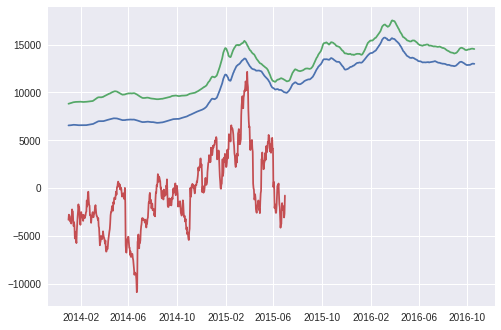

In [186]:
roll, roll1, shiftUE, poly  = 14,30,40,12
xLU = macro['usdrub'].rolling(roll).mean().dropna().shift(shiftUE)
xLE = macro['eurrub'].rolling(roll).mean().dropna().shift(shiftUE)
rr = ttrain[['r','timestamp']].set_index('timestamp')
rr = rr['r'].resample('D').mean().rolling(roll1,min_periods=1).mean()

#print(xLU.tail())

rue_data = pd.DataFrame();
rue_data['usd'] = xLU;
rue_data['r']  = rr
rue_data['eur']  = xLE
for i in range(2,poly) :
    rue_data['usd'+str(i)] = rue_data.usd**i
    rue_data['eur'+str(i)] = rue_data.eur**i
#print rue_data.tail()

plt.plot(rue_data[(rue_data.index>='2014')]['usd']*200); 
plt.plot(rue_data[(rue_data.index>='2014')]['eur']*200); 
plt.plot(rr[rr.index>='2014']-140000);
plt.show()
xLL = rue_data.copy().drop('r',axis=1); 
xLL = xLL.dropna();
rue_data = rue_data.dropna()
#xLL.head(), xLL.tail()

usd2+eur2+usd3+eur3+usd4+eur4+usd5+eur5+usd6+eur6+usd7+eur7+usd8+eur8+usd9+eur9+usd10+eur10+usd11+eur11
                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     449.2
Date:                Tue, 27 Jun 2017   Prob (F-statistic):               0.00
Time:                        23:00:23   Log-Likelihood:                -8716.5
No. Observations:                 911   AIC:                         1.745e+04
Df Residuals:                     900   BIC:                         1.751e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

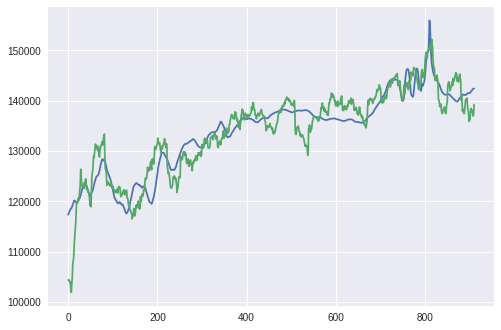

((2428, 2),       timestamp             LL
 2423 2016-10-15  146105.419239
 2424 2016-10-16  146119.050711
 2425 2016-10-17  145970.463726
 2426 2016-10-18  145820.491959
 2427 2016-10-19  145865.793190)

In [187]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

rue2014 = rue_data[rue_data.index>='2013']

rue_f = '+'.join(['usd'+str(i)+'+eur'+str(i) for i in range(2,poly)])
print(rue_f)
rue = sm.OLS.from_formula("r ~ usd+eur+"+rue_f, data=rue2014)
#rue = sm.OLS.from_formula("r ~ usd+eur", data=rue2014)
rue_m  = rue.fit()
print rue_m.summary()

rue = macro[['usdrub','eurrub']]; rue.columns=['usd','eur']

rue.usd = rue.usd.rolling(roll).mean().dropna().shift(shiftUE)
rue.eur = rue.eur.rolling(roll).mean().dropna().shift(shiftUE)
for i in range(2,poly) :
    rue['usd'+str(i)] = rue.usd**i
    rue['eur'+str(i)] = rue.eur**i
xLL = pd.DataFrame(rue_m.predict(rue),columns=['LL'])
rue2014['LL'] = xLL.LL
xLL = xLL.dropna().reset_index()
plt.plot(rue2014['LL'].ravel()); plt.plot(rue2014['r'].ravel()); 
plt.show()
xLL.shape, xLL.tail()


In [188]:
# Начинаем строить модель по остаткам train данных

In [189]:
col_res     = ['r'];
col_notuse  = ['usdm2full','usdm2life','eurm2full','eurm2life','price_doc','id','eur','usd','timestamp']+col_res
##col_notuse += ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year']

### begin 2017-06-04 after

col_notuse += ['build_year0','max_floor0'] #, 'full0'] #, 'life0']  #, 'floor0']
#######col_notuse += ['usdrub','eurrub'] 
col_notuse += ['life_sq','floor','full0']

col_notuse += ['material'] #'build-year'] # ???????????????????
#col_notuse += ['day','year','week','month'] # ???????????????????   22-06
##col_notuse += ['area_m','sub_area','state'] # ???????????????????  22-06
##col_notuse += ['state'] # ??????????????????? 22-06
##col_notuse += ['full_sq','max_floor'] # ??????????????????? 22-06


##################################################################
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if ntrain.dtypes[i]=='O']
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if len(ntrain[ntrain.columns[i]].unique())<=1]

col_use    = [ x for x in ttrain.columns.tolist() if x not in col_notuse];


In [190]:
#
#  Процедуры для синхронного построения из массивов (train, test, macro, ll) оценочных массивов (train_x, train_y, test_y)
#     в разных компоновочных вариантах
#

def ttConcat   (train,test,right) :
    train  = train.set_index('timestamp')
    test   = test.set_index('timestamp')
    right  = right.set_index('timestamp')
    
    ntrain, ntest = pd.concat([train,right],axis=1,join='inner'), pd.concat([test,right],axis=1,join='inner')
    
    train  = train.reset_index()
    test   = test.reset_index()
    right  = right.reset_index()
    
    ntrain = ntrain.reset_index()
    ntest  = ntest.reset_index()
    
    return ntrain, ntest

def pd1   (col_notuse,col_res,train,test) :
    col_use    = [ x for x in train.columns.tolist() if x not in col_notuse];
    return train[col_use],train[col_res],test[col_use]

def pd1m  (col_notuse,col_res,train,test,macro) :
    ntrain, ntest = ttConcat(train,test,macro)
    return pd1(col_notuse,col_res,ntrain,ntest)

def pd1l  (col_notuse,col_res,train,test,ll) :
    ntrain, ntest = ttConcat(train,test,ll)
    return pd1(col_notuse,col_res,ntrain,ntest)

def pd1ml (col_notuse,col_res,train,test,macro,ll) :
    print train.shape, test.shape
    ntrain, ntest = ttConcat(train,test,macro)
    print ntrain.shape, ntest.shape
    ntrain, ntest = ttConcat(ntrain,ntest,ll)
    print ntrain.shape, ntest.shape
    return pd1(col_notuse,col_res,ntrain,ntest)


In [205]:
col_notuse = col_notuse + col_not_use_imp
#train_x, train_y, test_x  = pd1ml (col_notuse,col_res,ttrain,ttest,nmacro,xLL)
#train_x, train_y, test_x  = pd1m (col_notuse,col_res,ttrain,ttest,nmacro)
#train_x, train_y, test_x  = pd1l (col_notuse,col_res,ttrain,ttest,xLL)
train_x, train_y, test_x  = pd1 (col_notuse,col_res,ttrain,ttest)
#train_x, train_y, test_x  = pd1l (col_notuse,col_res,ttrain,ttest,xLL)

print train.shape, train_x.shape, train_y.shape, test.shape, test_x.shape

(30471, 291) (30471, 77) (30471, 1) (7662, 290) (7662, 77)


In [207]:
#col_not_use_imp.tolist()
col_notuse

['usdm2full',
 'usdm2life',
 'eurm2full',
 'eurm2life',
 'price_doc',
 'id',
 'eur',
 'usd',
 'timestamp',
 'r',
 'build_year0',
 'max_floor0',
 'life_sq',
 'floor',
 'full0',
 'material',
 'young_male',
 'mosque_count_2000',
 '0_13_all',
 'mosque_count_500',
 'build_count_foam',
 '0_17_female',
 '0_13_female',
 'big_market_raion',
 'nuclear_reactor_raion',
 '7_14_all',
 'university_top_20_raion',
 '0_6_all',
 'big_church_count_500',
 '7_14_female',
 'railroad_1line',
 'cafe_count_2000_price_high',
 'build_count_mix',
 'culture_objects_top_25_raion',
 '7_14_male',
 'thermal_power_plant_raion',
 'water_1line',
 'trc_count_500',
 'cafe_count_1500_price_high',
 'cafe_count_500_price_4000',
 'big_road1_1line',
 'raion_build_count_with_builddate_info',
 '0_17_male',
 '16_29_female',
 '0_6_male',
 'cafe_count_3000_price_high',
 'female_f',
 'detention_facility_raion',
 'work_male',
 'build_count_frame',
 'work_all',
 'young_all',
 'cafe_count_1000_price_high',
 'leisure_count_500',
 'church_

In [208]:
# Не проходит, нет результативности # train_y.r  /= train_x.LL;

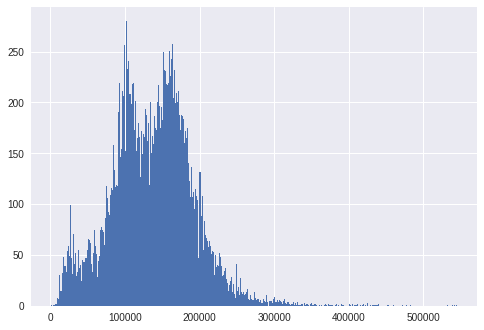

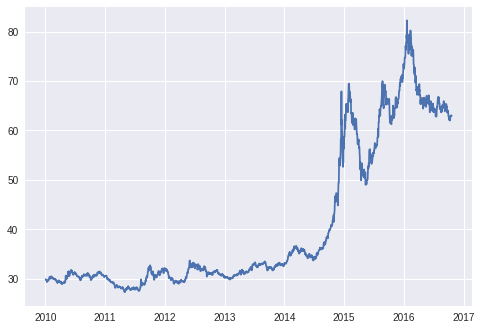

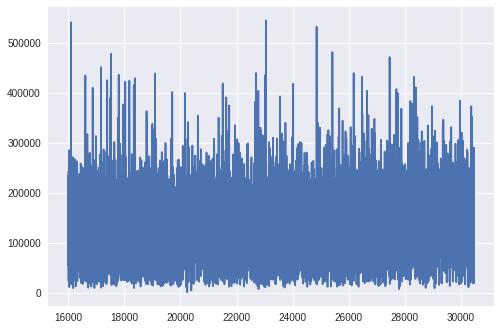

In [209]:
plt.hist(train_y[10000:].r.ravel(),bins=400); plt.show()
plt.plot(macro.usdrub); plt.show()
plt.plot(train_y[16000:]); plt.show()

In [210]:
print len(train),len(train_x)

30471 30471


In [211]:
import xgboost as xgb

def rmsle(preds, dtrain, dmatrix=True):
    if dmatrix : labels = dtrain.get_label()
    else : labels = dtrain
    assert len(preds) == len(labels)
    preds_ = np.abs(preds)
    logs   = np.log1p(labels)-np.log1p(preds_)
    logs2  = np.sqrt((logs*logs).mean())
    return 'rmsle', logs2

def rmsleSK(ground_true, preds):
    labels = ground_true
    assert len(preds) == len(labels)
    preds_ = np.abs(preds)
    logs   = np.log1p(labels)-np.log1p(preds_)
    logs2  = np.sqrt((logs*logs).mean())
    return -logs2

def xgbtrain (param, train_x, train_y, num_round=1800, stopping=10, ratio=0.9) :
    
    split = int(round(ratio*len(train_y)))
    dtrain = xgb.DMatrix(train_x[:split],label=train_y[:split])
    dvalid = xgb.DMatrix(train_x[split:],label=train_y[split:])
    watchlist  = [(dtrain,'train'),(dvalid,'valid')]
    rvalid={}
    bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=rvalid, early_stopping_rounds=stopping)
    return(bst,np.array(rvalid['valid']['rmse']))


In [212]:
# Строим основные массивы
dtrain = xgb.DMatrix(train_x,label=train_y)
dtest  = xgb.DMatrix(test_x)

In [213]:
#dtrainCV = xgb.DMatrix(train_x,label=train_y)
train_week_begin = 201400
train_week_tail  = 201500
train_xx    = train_x[train_x.year_week>=train_week_begin]
#train_xx_ll = train_xx.LL; 
#train_xx = train_xx.drop('LL',axis=1)
train_yy    = train_y[train_x.year_week>=train_week_begin]
dtrainCV    = xgb.DMatrix(train_xx,label=train_yy)
train_xx15  = train_x[train_x.year_week>=train_week_tail]
#train_xx15_ll = train_xx15.LL; 
#train_xx15 = train_xx15.drop('LL',axis=1)
train_yy15  = train_y[train_x.year_week>=train_week_tail]
dtrainCV2015= xgb.DMatrix(train_xx15,label=train_yy15)

In [214]:
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
##param = {'silent':0, 'objective':'reg:linear', 'eta':0.05, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
#param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':12, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':15, 'subsample':0.16, 'colsample_bytree':0.9399, 'metrics':'rmse'}
#param = {'silent':0, 'objective':'reg:linear', 'eta':0.05, 'max_depth':5, 'subsample':0.7, 'colsample_bytree':0.7, 'metrics':'rmse'}
# CV sklearn
param = {'silent':0, 'objective':'reg:linear', 'eta':0.01, 'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 'metrics':'rmse'}
param = {'silent':0, 'objective':'reg:linear', 'eta':0.01, 
         'max_depth':9, 'subsample':0.85, 'colsample_bytree':0.8, 
         'min_child_weight':12.0,
         'metrics':'rmse'}
history = xgb.cv(param, dtrainCV, verbose_eval=10, metrics=['rmse'],feval=rmsle,num_boost_round=1500,nfold=5,early_stopping_rounds=20) #,stratified=True,maximize=True)

[0]	train-rmsle:4.56994+0.000848767	test-rmsle:4.57209+0.0115699
[10]	train-rmsle:2.23678+0.000466921	test-rmsle:2.24236+0.00944316
[20]	train-rmsle:1.65224+0.000354961	test-rmsle:1.66019+0.0080315
[30]	train-rmsle:1.32356+0.000219137	test-rmsle:1.33384+0.00665017
[40]	train-rmsle:1.10399+0.000294697	test-rmsle:1.11688+0.00556754
[50]	train-rmsle:0.9454+0.000548148	test-rmsle:0.961091+0.0045628
[60]	train-rmsle:0.825576+0.000820559	test-rmsle:0.844362+0.00381002
[70]	train-rmsle:0.732755+0.00116578	test-rmsle:0.754717+0.00344692
[80]	train-rmsle:0.65963+0.00149866	test-rmsle:0.68479+0.00387381
[90]	train-rmsle:0.601511+0.0017716	test-rmsle:0.62992+0.00467033
[100]	train-rmsle:0.555102+0.00203477	test-rmsle:0.586693+0.00578898
[110]	train-rmsle:0.517795+0.00228163	test-rmsle:0.552558+0.00699013
[120]	train-rmsle:0.4878+0.00258234	test-rmsle:0.525661+0.00827861
[130]	train-rmsle:0.463714+0.00288621	test-rmsle:0.504472+0.00944455
[140]	train-rmsle:0.444296+0.00312845	test-rmsle:0.487841+0

In [215]:
watchlistCV  = [(dtrainCV,'train')]
rvalidCV = {}
bstCV = xgb.train(param, dtrainCV, history['test-rmsle-mean'].argmin()+2, watchlistCV, evals_result=rvalidCV, feval=rmsle)
##bstCV = xgb.train(param, dtrainCV, history['test-rmse-mean'].argmin()+2, watchlistCV, evals_result=rvalidCV)

train_cv = bstCV.predict(dtrainCV)
train_cv = np.abs(train_cv)
_,train_rmsle_CV     = rmsle(train_cv,dtrainCV)

train_cv_tail = bstCV.predict(dtrainCV2015)
train_cv_tail = np.abs(train_cv_tail)
_,train_rmsle_CV2015 = rmsle(train_cv_tail,dtrainCV2015)

if False :
    bst, rvalid_log = xgbtrain(param, train_x, train_y, num_round=1800, stopping=30, ratio=0.9)

    train_cv = bst.predict(dtrainCV,ntree_limit=rvalid_log.argmin())
    train_cv = np.abs(train_cv)
    _,train_rmsle = rmsle(train_cv,dtrainCV)

[0]	train-rmsle:4.57031
[1]	train-rmsle:3.88271
[2]	train-rmsle:3.48411
[3]	train-rmsle:3.20311
[4]	train-rmsle:2.98698
[5]	train-rmsle:2.81087
[6]	train-rmsle:2.66292
[7]	train-rmsle:2.53602
[8]	train-rmsle:2.42446
[9]	train-rmsle:2.32557
[10]	train-rmsle:2.23648
[11]	train-rmsle:2.15573
[12]	train-rmsle:2.082
[13]	train-rmsle:2.01423
[14]	train-rmsle:1.95157
[15]	train-rmsle:1.89334
[16]	train-rmsle:1.83908
[17]	train-rmsle:1.78802
[18]	train-rmsle:1.74013
[19]	train-rmsle:1.69507
[20]	train-rmsle:1.6524
[21]	train-rmsle:1.612
[22]	train-rmsle:1.57363
[23]	train-rmsle:1.5372
[24]	train-rmsle:1.50251
[25]	train-rmsle:1.46934
[26]	train-rmsle:1.43768
[27]	train-rmsle:1.40743
[28]	train-rmsle:1.37846
[29]	train-rmsle:1.35065
[30]	train-rmsle:1.32397
[31]	train-rmsle:1.29819
[32]	train-rmsle:1.2734
[33]	train-rmsle:1.24955
[34]	train-rmsle:1.22663
[35]	train-rmsle:1.20442
[36]	train-rmsle:1.18301
[37]	train-rmsle:1.16231
[38]	train-rmsle:1.14238
[39]	train-rmsle:1.12308
[40]	train-rmsle:

In [216]:
import sklearn.metrics as skme
#print(history['test-rmsle-mean'].min(),history['test-rmsle-mean'].argmin(),history['train-rmsle-mean'][history['test-rmsle-mean'].argmin()])
print ' cv={}, er={}, er-tail={},\n R2={}, R2(tail)={},\n mae={}, mae-tail={},\n mse={}, mse-tail={}'.format(history['test-rmsle-mean'].min(),train_rmsle_CV, train_rmsle_CV2015, 
                                                                    skme.r2_score(dtrainCV.get_label(),train_cv), 
                                                                    skme.r2_score(dtrainCV2015.get_label(),train_cv_tail),
                                                                    skme.mean_absolute_error(dtrainCV.get_label(),train_cv),
                                                                    skme.mean_absolute_error(dtrainCV2015.get_label(),train_cv_tail),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV.get_label(),train_cv)),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV2015.get_label(),train_cv_tail))
                                                                   )
#plt.plot(history['test-rmsle-mean']); plt.show()

 cv=0.4337102, er=0.369311451912, er-tail=0.325571119785,
 R2=0.695459425393, R2(tail)=0.729794796703,
 mae=21398.9023438, mae-tail=20776.2324219,
 mse=30972.109375, mse-tail=29828.0488281


In [201]:
import sklearn.metrics as skme
#print(history['test-rmsle-mean'].min(),history['test-rmsle-mean'].argmin(),history['train-rmsle-mean'][history['test-rmsle-mean'].argmin()])
print ' cv={}, er={}, er-tail={},\n R2={}, R2(tail)={},\n mae={}, mae-tail={},\n mse={}, mse-tail={}'.format(history['test-rmsle-mean'].min(),train_rmsle_CV, train_rmsle_CV2015, 
                                                                    skme.r2_score(dtrainCV.get_label(),train_cv), 
                                                                    skme.r2_score(dtrainCV2015.get_label(),train_cv_tail),
                                                                    skme.mean_absolute_error(dtrainCV.get_label(),train_cv),
                                                                    skme.mean_absolute_error(dtrainCV2015.get_label(),train_cv_tail),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV.get_label(),train_cv)),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV2015.get_label(),train_cv_tail))
                                                                   )
#plt.plot(history['test-rmsle-mean']); plt.show()

 cv=0.4337324, er=0.367599070072, er-tail=0.324255675077,
 R2=0.698124296937, R2(tail)=0.73023542071,
 mae=21589.5117188, mae-tail=21015.9316406,
 mse=30836.3007812, mse-tail=29803.7167969


 cv=0.434347, er=0.340219855309, er-tail=0.299397110939,
 R2=0.741306929397, R2(tail)=0.760599530366,
 mae=20416.2148438, mae-tail=20219.1464844,
 mse=28545.6933594, mse-tail=28076.3398438


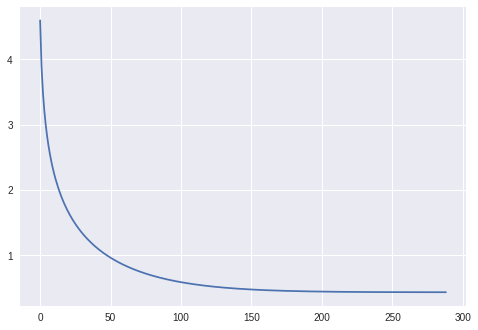

In [35]:
import sklearn.metrics as skme
#print(history['test-rmsle-mean'].min(),history['test-rmsle-mean'].argmin(),history['train-rmsle-mean'][history['test-rmsle-mean'].argmin()])
print ' cv={}, er={}, er-tail={},\n R2={}, R2(tail)={},\n mae={}, mae-tail={},\n mse={}, mse-tail={}'.format(history['test-rmsle-mean'].min(),train_rmsle_CV, train_rmsle_CV2015, 
                                                                    skme.r2_score(dtrainCV.get_label(),train_cv), 
                                                                    skme.r2_score(dtrainCV2015.get_label(),train_cv_tail),
                                                                    skme.mean_absolute_error(dtrainCV.get_label(),train_cv),
                                                                    skme.mean_absolute_error(dtrainCV2015.get_label(),train_cv_tail),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV.get_label(),train_cv)),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV2015.get_label(),train_cv_tail))
                                                                   )
plt.plot(history['test-rmsle-mean']); plt.show()

In [216]:
print '%s))' % '123'

123))


In [56]:
import sklearn.metrics as skme
import sklearn.model_selection as skms

#cvtest_param  = {'max_depth':range(5,19,2),'subsample':[0.3,0.5,0.7,0.8], 'colsample_bytree':[0.6,0.7,0.8,0.9,0.99]}
cvtest_param  = {'max_depth':[9],'subsample':[0.725,0.75,0.775,0.8,0.825,0.85,0.875], 'colsample_bytree':[0.8]}
cvtest_param  = {'max_depth':[9],'subsample':[0.85], 'colsample_bytree':[0.725,0.75,0.775,0.8,0.825,0.85,0.875]}
cvtest_param  = {'max_depth':[9],'subsample':[0.85], 'colsample_bytree':[0.8],
                 #'tree_method':['exact'],
                 'min_child_weight':[float(i) for i in range(11,14,1)]}

rmsleScorer   = skme.make_scorer(rmsleSK)
cvtest_search = skms.GridSearchCV(estimator = xgb.XGBRegressor( learning_rate=0.05, n_estimators=200), 
                                  param_grid = cvtest_param, n_jobs=1, cv=5, verbose=3, scoring=rmsleScorer)
print train_xx.shape, train_yy.shape
#cvtest_search.fit(train_xx,train_yy,eval_metric=[rmsle],early_stopping_rounds=20)
cvtest_search.fit(train_xx,train_yy.values)
cvtest_search.grid_scores_, cvtest_search.best_params_, cvtest_search.best_score_

(16901, 307) (16901, 1)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.594102, total=   9.9s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.605000, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s


[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.600351, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.573735, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.574877, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0, score=-0.592932, total=   9.9s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0, score=-0.604719, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_de

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.7min finished
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58961, std: 0.01297, params: {'subsample': 0.85, 'colsample_bytree': 0.8, 'max_depth': 9, 'min_child_weight': 11.0},
  mean: -0.58869, std: 0.01302, params: {'subsample': 0.85, 'colsample_bytree': 0.8, 'max_depth': 9, 'min_child_weight': 12.0},
  mean: -0.58942, std: 0.01226, params: {'subsample': 0.85, 'colsample_bytree': 0.8, 'max_depth': 9, 'min_child_weight': 13.0}],
 {'colsample_bytree': 0.8,
  'max_depth': 9,
  'min_child_weight': 12.0,
  'subsample': 0.85},
 -0.5886864544237006)

In [57]:
cvtest_search.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=12.0, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.85)

In [217]:
###############################################################

In [218]:
# Строим результат

In [219]:
#test_x_ll = test_x.LL; test_x = test_x.drop('LL',axis=1)
dtest = xgb.DMatrix(test_x)
#test_p = bst.predict(dtest,ntree_limit=rvalid_log.argmin())
test_p = bstCV.predict(dtest)
#test_p = bst.predict(dtest)
test_p = np.abs(test_p)
#test_x['LL'] = test_x_ll

In [220]:
test_r = pd.DataFrame(ttest[['id']]); 
##test_r['price_doc']=np.expm1(test_p)*(test_x.full_sq+1)*test_x.usdrub # 2017-06-02 LB = 0.54
##test_r['price_doc'] = test_p*(test_x.full_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.361
##test_r['price_doc'] = test_p*(test_x.full_sq+1); # 2017-06-02 LB = 0.41066
##test_r['price_doc'] = test_p*(test_x.life_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.39

#test_r['price_doc'] = test_p*test_x.life0*test_x.usdrub; # 2017-06-02 LB = 0.37543
#test_r['price_doc'] = test_p*ttest.full0*ttest.usdrub; # 2017-06-02 LB = 0.37296
#test_r['price_doc'] = test_p # 2017-06-21 LB = 0.31954
#test_r['price_doc'] = test_p*test_x.life0 # 2017-06-24 LB = 0.31770 
#test_r['price_doc'] = test_p*ttest.full0/ttest['life:full'] # 2017-06-22 LB = 0.34990 ????
#test_r['price_doc'] = test_p*testUsdEur.full0*testUsdEur.usdrub # 2017-06-22 LB = 0.34990 ????

test_r['price_doc'] = test_p*testUsdEur.full0 # 2017-06-25 LB = 0.31640
##test_r['price_doc'] = test_p*(testUsdEur.full0+testUsdEur.life0)/2 # 2017-06-25 LB = 0.31726 (worst) 
##test_r['price_doc'] = test_p*testUsdEur.full0/ttest['life:full'] # 2017-06-25 LB = 0.31991
#test_r['price_doc'] = test_p*testUsdEur.full0*test_x.LL # 2017-06-26 LB >0.32

print test_r.price_doc.min(),test_r.price_doc.max(),train.price_doc.min(),train.price_doc.max() 
test_r.head(8)
#test_r.tail(8)
#test_r.shape

268933.0 94084858.5625 100000 111111112


,id,price_doc
0,30474,5.187604e+06
1,30475,8.434172e+06
2,30476,5.332646e+06
3,30477,5.991378e+06
4,30478,5.023620e+06
5,30479,8.835181e+06
6,30480,4.278126e+06
7,30481,4.219877e+06


In [221]:
ntest[test_r.price_doc<0.0]

,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000


In [157]:
# Результат в файл

In [222]:
test_r[['id','price_doc']].to_csv('../Result/res-86.csv',index=False)

In [223]:
test0 = pd.read_csv('../Result/res-75.csv')
test1 = pd.read_csv('../Result/res-86.csv')
test2 = pd.read_csv('../Result/res-85.csv')
test_rmsle = rmsle(test1.price_doc,test2.price_doc,dmatrix=False)
print rmsle(test0.price_doc,test1.price_doc,dmatrix=False), skme.r2_score(test0.price_doc,test1.price_doc), skme.mean_absolute_error(test0.price_doc,test1.price_doc)
print rmsle(test0.price_doc,test2.price_doc,dmatrix=False), skme.r2_score(test0.price_doc,test2.price_doc), skme.mean_absolute_error(test0.price_doc,test2.price_doc)
print rmsle(test1.price_doc,test2.price_doc,dmatrix=False), skme.r2_score(test1.price_doc,test2.price_doc), skme.mean_absolute_error(test1.price_doc,test2.price_doc)
print rmsle(test2.price_doc,test1.price_doc,dmatrix=False), skme.r2_score(test2.price_doc,test1.price_doc), skme.mean_absolute_error(test2.price_doc,test1.price_doc)

('rmsle', 0.054657677275894802) 0.981105625288 271400.206688
('rmsle', 0.037918511181292539) 0.991109373196 179399.381886
('rmsle', 0.042372010015824302) 0.989023072205 226981.486301
('rmsle', 0.042372010015824302) 0.989048306144 226981.486301


In [ ]:
#-------------------------------------------------------------------------------------------

In [202]:
fff = bstCV.get_fscore()
fff = pd.DataFrame(fff.values(),index=fff.keys(),columns=['imp'])
ffs = fff.sort_values('imp')
print ffs.ix[['full_sq','LL','material','day','year','month','week']]
ffs.tail(60)
#ffs.head(60)
#ffs[-120:-60]

             imp
full_sq   1801.0
LL           NaN
material     NaN
day        376.0
year        27.0
month      187.0
week       316.0


,imp
ice_rink_km,266
ts_km,267
big_road2_km,272
railroad_station_walk_km,273
prom_part_3000,275
kitch_sq,278
green_part_2000,279
power_transmission_line_km,280
prom_part_1000,280
big_road1_km,282


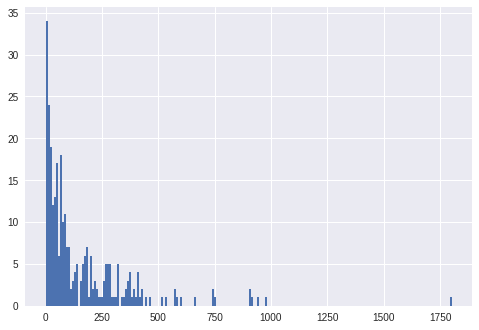

In [203]:
plt.hist(ffs.imp,bins=200); plt.show()

In [204]:
col_not_use_imp = ffs.index[ffs.imp<250].values.tolist()
print(len(col_not_use_imp ))
col_not_use_imp

228


['young_male',
 'mosque_count_2000',
 '0_13_all',
 'mosque_count_500',
 'build_count_foam',
 '0_17_female',
 '0_13_female',
 'big_market_raion',
 'nuclear_reactor_raion',
 '7_14_all',
 'university_top_20_raion',
 '0_6_all',
 'big_church_count_500',
 '7_14_female',
 'railroad_1line',
 'cafe_count_2000_price_high',
 'build_count_mix',
 'culture_objects_top_25_raion',
 '7_14_male',
 'thermal_power_plant_raion',
 'water_1line',
 'trc_count_500',
 'cafe_count_1500_price_high',
 'cafe_count_500_price_4000',
 'big_road1_1line',
 'raion_build_count_with_builddate_info',
 '0_17_male',
 '16_29_female',
 '0_6_male',
 'cafe_count_3000_price_high',
 'female_f',
 'detention_facility_raion',
 'work_male',
 'build_count_frame',
 'work_all',
 'young_all',
 'cafe_count_1000_price_high',
 'leisure_count_500',
 'church_count_500',
 'big_church_count_1000',
 '16_29_male',
 'school_education_centers_top_20_raion',
 'market_count_1000',
 'young_female',
 'ID_bus_terminal',
 'culture_objects_top_25',
 'radiat

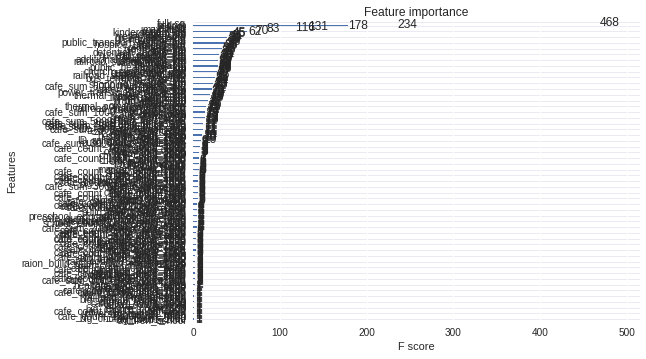

In [61]:
aax = plt.figure(figsize=(16, 16));
xgb.plot_importance(bst); 
#xgb.plot_tree(bst); 
plt.show()

In [8]:
temp=pd.DataFrame(ttrain.columns);

In [9]:
ttrain['sub_area'].unique()

array(['Bibirevo', 'Nagatinskij Zaton', "Tekstil'shhiki", 'Mitino',
       'Basmannoe', 'Nizhegorodskoe', "Sokol'niki", 'Koptevo', 'Kuncevo',
       'Kosino-Uhtomskoe', 'Zapadnoe Degunino', 'Presnenskoe', 'Lefortovo',
       "Mar'ino", "Kuz'minki", 'Nagornoe', "Gol'janovo", 'Vnukovo',
       'Juzhnoe Tushino', 'Severnoe Tushino', "Chertanovo Central'noe",
       'Fili Davydkovo', 'Otradnoe', 'Novo-Peredelkino', 'Bogorodskoe',
       'Jaroslavskoe', 'Strogino', 'Hovrino', "Moskvorech'e-Saburovo",
       'Staroe Krjukovo', 'Ljublino', 'Caricyno', 'Veshnjaki',
       'Danilovskoe', 'Preobrazhenskoe', "Kon'kovo", 'Brateevo',
       'Vostochnoe Izmajlovo', 'Vyhino-Zhulebino', 'Donskoe',
       'Novogireevo', 'Juzhnoe Butovo', 'Sokol', 'Kurkino', 'Izmajlovo',
       'Severnoe Medvedkovo', 'Rostokino', 'Orehovo-Borisovo Severnoe',
       'Ochakovo-Matveevskoe', 'Taganskoe', 'Dmitrovskoe',
       'Orehovo-Borisovo Juzhnoe', 'Teplyj Stan', 'Babushkinskoe',
       'Pokrovskoe Streshnevo', 'Obruc

In [7]:
print(' train=',train.index.min(),train.index.max())
print('ttrain=',ttrain.index.min(),ttrain.index.max())

(' train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('ttrain=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))


In [183]:
acf,confint,qstat,pvalues = sm.tsa.stattools.acf(xtrain,nlags=600,alpha=0.05,qstat=True,fft=True)
#acf
confint.shape #[-10:]
#qstat[-10:]
#pvalues[-10:]
acf[acf>3*confint[:,0]]
#acf.shape, confint.shape
acf[177:185], confint[177:185], qstat[177:185], pvalues[177:185]

(array([ 0.05687618,  0.01495214,  0.01454301,  0.12218533,  0.01729215,
         0.01492026,  0.01349208,  0.01702206]),
 array([[ 0.04518074,  0.06857162],
        [ 0.00322188,  0.02668239],
        [ 0.00281035,  0.02627567],
        [ 0.1104504 ,  0.13392027],
        [ 0.00539791,  0.02918638],
        [ 0.00302285,  0.02681767],
        [ 0.00159232,  0.02539185],
        [ 0.00512036,  0.02892375]]),
 array([ 1404.55727916,  1411.04037485,  1868.68299746,  1877.84943322,
         1884.673916  ,  1890.25462559,  1899.13783036,  1903.71613167]),
 array([  1.93568353e-189,   3.20097876e-190,   2.63858406e-278,
          1.34856387e-279,   1.98803802e-280,   5.14158124e-281,
          2.98600922e-282,   1.21397189e-282]))